In [17]:
!pip install transformers datasets evaluate accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import evaluate
import numpy as np
import pandas as pd

In [19]:
df = pd.read_csv("/kaggle/input/webtexts-en/all-codes-small.csv", usecols=["label", "text"])
df

,label,text
0,error,Domain misconfigured\tThis domain points to Sh...
1,error,410 - Page Archived\tMinistry of Justice\tThis...
2,error,AQW\tHomepage\tNew Releases\tEncyclopedia\t+ W...
3,error,Page Not Found - Artikel Nolimit City\tSkip to...
4,error,406 Not Acceptable\tNot Acceptable\tAn appropr...
...,...,...
41193,content,GrainGenes | A Database for Triticeae and Aven...
41194,content,When We Dip | Harvard Bass Archives - When We ...
41195,content,Account Suspended\tAccount Suspended\tThis Acc...
41196,content,Poltergeists by Alan Gauld and A. D. Cornell |...


In [20]:
df["label_int"] = (df["label"] == "error").astype(int)

In [21]:
X_train, X_test, y_train, y_test  = train_test_split(
        df["text"], 
        df["label_int"],
        train_size=0.80,
        random_state=1234)

df_train = pd.DataFrame({"label": y_train, "text": X_train}).reset_index(drop=True)
df_test = pd.DataFrame({"label": y_test, "text": X_test}).reset_index(drop=True)

In [22]:
dsd = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "test": Dataset.from_pandas(df_test)
})

In [23]:
 tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [24]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [25]:
tokenized_dsd = dsd.map(preprocess_function, batched=True)

Map:   0%|          | 0/32958 [00:00<?, ? examples/s]

Map:   0%|          | 0/8240 [00:00<?, ? examples/s]

In [26]:
clf_metrics = evaluate.combine(["accuracy", "precision", "recall", "f1"])

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return clf_metrics.compute(predictions=predictions, references=labels)

In [27]:
id2label = {0: "content", 1: "error"}
label2id = {"content": 0, "error": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dsd["train"],
    eval_dataset=tokenized_dsd["test"],
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

In [29]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.067100,0.053004,0.985558,0.987094,0.984505,0.985798
2,0.039900,0.043897,0.989806,0.993281,0.986651,0.989955


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=2060, training_loss=0.06608206971177777, metrics={'train_runtime': 1983.3282, 'train_samples_per_second': 33.235, 'train_steps_per_second': 1.039, 'total_flos': 8720933236030848.0, 'train_loss': 0.06608206971177777, 'epoch': 2.0})

In [30]:
trainer.save_model("distilbert-model")

In [31]:
!zip -r distilbert-model.zip distilbert-model

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


updating: distilbert-model/ (stored 0%)
updating: distilbert-model/tokenizer.json (deflated 71%)
updating: distilbert-model/vocab.txt (deflated 53%)
updating: distilbert-model/tokenizer_config.json (deflated 76%)
updating: distilbert-model/config.json (deflated 48%)
updating: distilbert-model/model.safetensors (deflated 8%)
updating: distilbert-model/special_tokens_map.json (deflated 42%)
updating: distilbert-model/training_args.bin (deflated 51%)


In [34]:
from IPython.display import FileLink

from datetime import datetime
FileLink("distilbert-model.zip")

/kaggle/working/distilbert-model.zip

In [35]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis" ,model="./distilbert-model")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [36]:
df_real = pd.read_csv("/kaggle/input/webtexts-en/dataset-test.csv")

In [38]:
results = classifier(df_real["text"].tolist(), truncation=True)
df_real["pred"] = [r["label"] for r in results]

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

def show_metrics(model, y_true, y_pred):
    print("Model", model)
    print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    print("Precision: {}".format(precision_score(y_true, y_pred, pos_label="error")))
    print("Recall: {}".format(recall_score(y_true, y_pred, pos_label="error")))
    print("F1: {}".format(f1_score(y_true, y_pred, pos_label="error")))
    
    labels = ['error', 'content']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    sns.heatmap(cm, 
                annot=True,
                fmt='g', 
                xticklabels=labels,
                yticklabels=labels)
    plt.ylabel('Actual', fontsize=13)
    plt.title('{} Confusion Matrix'.format(model), fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()
    
    # plt.gca().figure.subplots_adjust(bottom=0.2)
    # plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

Model DistilBERT
Accuracy: 0.8536585365853658
Precision: 0.9340659340659341
Recall: 0.7798165137614679
F1: 0.85


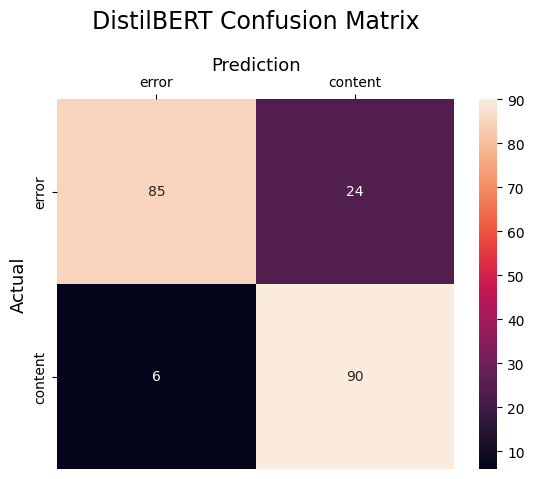

In [43]:
show_metrics("DistilBERT", df_real["label"].tolist(), df_real["pred"].tolist())

In [45]:
df_diff = df_real.query("label != pred")
for index, row in df_diff.iterrows():
    print("Status code:", row["status_code"])
    print("Label:", row["label"])
    print("Predicted:", row["pred"])
    print("Content_type:", row["content_type"])
    print("URL:", row["url"])
    print("Text:\n{}".format(row["text"]))
    print("\n========================================\n")

Status code: 200
Label: error
Predicted: content
Content_type: text/html
URL: https://andyriga.wordpress.com/e7aef43b-edde-490a-a95f-a31d978d2bee
Text:
Private Site	Build a website. Sell your stuff. Write a blog. And so much more.	Log in	Start your website	Private Site	This site is currently private.	Log in to WordPress.com	to request access.


Status code: 200
Label: error
Predicted: content
Content_type: text/html
URL: https://aqicn.org/e7aef43b-edde-490a-a95f-a31d978d2bee
Text:
China Air Pollution: Real-time Air Quality Index (AQI)	home	Here	map	mask	faq	search	contact	links	404!	Enter a city name	↓ ↓ ↓	or let us find your nearest air quality monitoring station	Please wait while querying your location...	Previously visited stations:	About the Air Quality Levels	AQI	Air Pollution Level	Health Implications	Cautionary Statement (for PM2.5)	0 - 50	Good	Air quality is considered satisfactory, and air pollution poses little or no risk	None	51 -100	Moderate	Air quality is acceptable; howev